In [1]:
import tensorflow as tf
import numpy as np
import random
import os
from glob import glob
import time, datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
%load_ext tensorboard

In [2]:
tf.__version__

'2.7.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Checking our Data and Visualizing

You can check my [Data Preprocessing](https://github.com/jjaimwork/Food-Vision-From-Scratch/tree/master) Notebook for and how I managed to generate my dataset.

### Parsing through our data

In [4]:
data_dir = 'Food-Vision-REDO/datasets/all_data_set/'
test_dir = 'Food-Vision-REDO/datasets/all_data_set/test/'
train_dir = 'Food-Vision-REDO/datasets/all_data_set/test/'

for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'Food-Vision-REDO/datasets/all_data_set/'.
There are 10 directories and 0 images in 'Food-Vision-REDO/datasets/all_data_set/test'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\baklava'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\chicken_wings'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\filet_mignon'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\gyoza'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\paella'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\peking_duck'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\sashimi'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\scallops'.
There are 0 directories and 250 images i

### Generating a list of classes

In [5]:
class_list = glob(os.path.join(test_dir, '*',))
class_list = [i.split('\\')[-1] for i in class_list]
class_list

['baklava',
 'chicken_wings',
 'filet_mignon',
 'gyoza',
 'paella',
 'peking_duck',
 'sashimi',
 'scallops',
 'spring_rolls',
 'tuna_tartare']

### Visualizing Random Images

In [6]:
def plot_random_image(class_list, directory):
    
    '''
    Takes in a list of classes which randomly selects an image in its directory
    
    
    Parameters
    --------
    class_list - list of classes(similar to its folder name)
    directory - location of images you would want to view
    '''
    
    random_class = random.choice(class_list)
    random_dir = directory + random_class
    random_img = random.choice(os.listdir(random_dir))
    rng_dir_img = random_dir + '/' + random_img
    arr_dir_img = mpimg.imread(rng_dir_img)
    
    img=plt.imshow(arr_dir_img)
    plt.axis(False)
    plt.title(f'class:{random_class}\n shape:{arr_dir_img.shape}\n {random_img}')
    return img

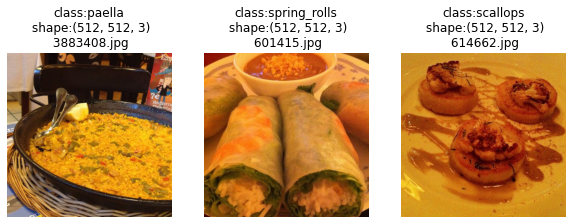

In [7]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.subplot(1,3,i)
    plot_random_image(class_list, test_dir)

## What is a Convolutional Neural Networks and how does it work?

CNNs basically a neural network where for complexities of data in terms of; image and video processing, and it learns and recognizes patterns within that input which is then filtered for `n` amount of times with regards to the problem at hand which in turn uses the `weights(which are the patterns learned)` to help with object detection.

See [CNN Explainer Website](https://poloclub.github.io/cnn-explainer/) a much detailed explanation

Generally a CNN has hyperparameters of the following: 
* **`Input Size`**- the shape of the image in terms of pixel size (h/w)
* **`Padding`** - conserves the outside borders of the image
* **`Kernel Size`** - amount of square windows that will go through the input layer(think of it as generating minibatches) and generates a single window/pixel of condensed weights it has learned
* **`Stride`** - affects the output layer on how much compression of information it sets, can also be affect by the Kernel Size

## Building a CNN Model from Scratch

#### Importing data from directory

In [8]:
# importing our data
train_dir = './Food-Vision-REDO/datasets/all_data_set/train/'
test_dir = './Food-Vision-REDO/datasets/all_data_set/test/'

#### Understanding Callbacks

Callbacks generates functionalities that would deem helpful during or after training, they generate: **logs, checkpoints and also early stopping** which are the most common

**Tensorboard Callback** - generates logs of training files that can be interacted with Tensorboard itself.

**Checkpoint Callback** - generates a checkpoint where it saves incase something happens, this is generally helpful when we're going to train for longer periods to build backups just incase.

In [9]:
# Building a Tensorboard Function

def create_tensorboard_callback(dir_name, experiment_name):
    '''
    creates a tensorboard callback logs file
    
    dirname / logs/fits / experiment_name / datetime
    
    Parameters
    -------
    dir_name - project path name where logs will be stored
    experiment_name - specific name of the model path you'd want to generate
    
    %load_ext tensorboard
    tensorboard --logdir='' --host localhost
    '''
    log_dir = dir_name + '/' + 'logs/fits' + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving Tensorboard logfiles to {log_dir}')
    return tensorboard_callback

In [10]:
checkpoint_path = './Food-Vision-REDO/checkpoint/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch',
    verbose=1
)
    

#### Generating a base model

We'd generally make a base model and try to improve it by beating it throughout each experimentation.

In [11]:
# normalize the rgb values to 0-1
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# creating mini batches of categorical data and reshaping them into 224,224
train_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode='categorical',
    target_size=(224,224) 
)

test_data = test_datagen.flow_from_directory(
    test_dir, 
    batch_size=32,
    class_mode='categorical',
    target_size=(224,224)
)

# building our base model


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [12]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10,3, activation='relu'),
    tf.keras.layers.Conv2D(10,3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# compiling
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# fitting and saving its history
model_1_history = model_1.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback("./Food-Vision-REDO/transfer_learning", "10_percent_feature_extract")]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning/logs/fits/10_percent_feature_extract/20211114-210032
Epoch 1/5
235/235 [==============================] - 88s 361ms/step - loss: 2.2119 - accuracy: 0.1695 - val_loss: 2.0729 - val_accuracy: 0.2260
Epoch 2/5
235/235 [==============================] - 31s 132ms/step - loss: 1.9797 - accuracy: 0.2981 - val_loss: 1.9688 - val_accuracy: 0.2928
Epoch 3/5
235/235 [==============================] - 31s 133ms/step - loss: 1.6818 - accuracy: 0.4187 - val_loss: 1.9837 - val_accuracy: 0.3156
Epoch 4/5
235/235 [==============================] - 31s 132ms/step - loss: 1.2046 - accuracy: 0.5937 - val_loss: 2.2626 - val_accuracy: 0.2812
Epoch 5/5
235/235 [==============================] - 31s 133ms/step - loss: 0.6093 - accuracy: 0.8025 - val_loss: 3.0871 - val_accuracy: 0.2704


In [13]:
model_1.evaluate(test_data)

79/79 [==============================] - 8s 97ms/step - loss: 3.0871 - accuracy: 0.2704


[3.087146759033203, 0.2703999876976013]

In [14]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [15]:
def plot_history_curves(model):
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    
    accuracy = model.history['accuracy']
    val_accuracy = model.history['val_accuracy']
    
    epochs = range(len(model.history['loss']))
    
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss[lower == better]')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Val Accuracy')
    plt.title('Accuracy[higher==better]')
    plt.xlabel('Epochs')
    plt.legend()

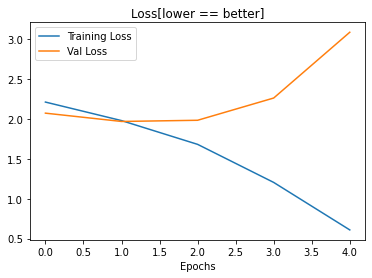

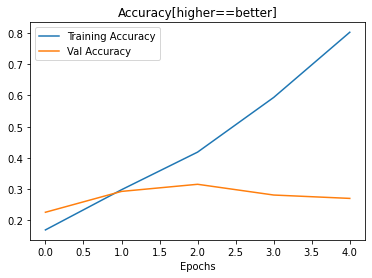

In [16]:
plot_history_curves(model_1_history)

Our model is overfitting.

In [17]:
#tensorboard --logdir='Food-Vision-REDO/transfer_learning/' --host localhost 

### Overcoming Overfitting

Based from the graph above we can say our model is overfitting

Overfitting generally happens when our model **IS** learning on the training set, but doesn't really perform well with the validation set as seen in the graphs.

How to overcome overfitting: 

* **Get more data** - Get more data, having more data == more patterns to learn from. (we already have a wide variety of images)
* **Simplify model** - Overfitting would simply mean literally perfectly or too strong in the training set that its using those memorized features instead of learning and actually applying what it's learned to the test/validation
* **Use Data Augmentation** - Generating different patterns of the image so the model would take a hard time learning as it adds different varieties of patterns to learn from. 
* **Use Transfer Learning** - By utilizing models that have already and been pretrained and use those patterns for our own problems

>  Overfitting happens the Accuracy and Loss separate from each other which would mean using;   

        * needing more data, simplifying the model, augmenting the data, transfer learning 
        
> for Underfitting, our Accuracy and Loss would stick together which would mean using;

        * a stronger model

#### Simplifying the Model

We can simplify our model by reducing each layer within the `Sequential Layer`


In [18]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_2_history = model_2.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
235/235 [==============================] - 32s 133ms/step - loss: 2.1137 - accuracy: 0.2388 - val_loss: 1.9532 - val_accuracy: 0.2880
Epoch 2/5
235/235 [==============================] - 31s 134ms/step - loss: 1.7606 - accuracy: 0.3916 - val_loss: 1.9179 - val_accuracy: 0.3316
Epoch 3/5
235/235 [==============================] - 31s 133ms/step - loss: 1.3885 - accuracy: 0.5336 - val_loss: 2.0734 - val_accuracy: 0.3084
Epoch 4/5
235/235 [==============================] - 31s 133ms/step - loss: 0.9331 - accuracy: 0.7048 - val_loss: 2.2621 - val_accuracy: 0.2996
Epoch 5/5
235/235 [==============================] - 31s 133ms/step - loss: 0.5530 - accuracy: 0.8409 - val_loss: 2.6636 - val_accuracy: 0.2916


In [19]:
model_2.evaluate(test_data)

79/79 [==============================] - 8s 102ms/step - loss: 2.6636 - accuracy: 0.2916


[2.663577079772949, 0.29159998893737793]

In [20]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 29160)             0         
                                                                 
 dense_1 (Dense)             (None, 10)               

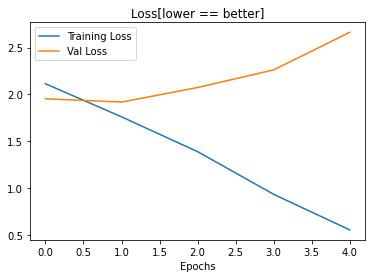

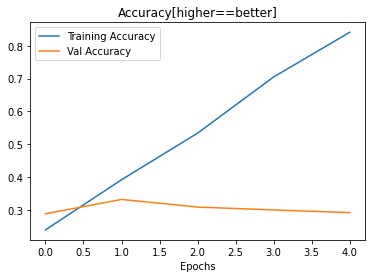

In [21]:
plot_history_curves(model_2_history)

Generally better than our base model, yet our model is still overfitting and not learning any better.

#### Data Augmentation 

`Data Augmentation` is diversifying the images by instead of just seeing it as it is and learning from it; ideally in the real world we view stuff in different perspectives/angles/range which means by increasing the diversity of the images thus would produce a better model to detect images it hasn't seen before.

In [22]:
train_augmented_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_data_augmentmented = train_augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


##### Data Augmentation with CPU

In [23]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3_history = model_3.fit(
    train_data_augmentmented,
    epochs=5,
    steps_per_epoch=len(train_data_augmentmented),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
235/235 [==============================] - 90s 380ms/step - loss: 2.2086 - accuracy: 0.1753 - val_loss: 2.1126 - val_accuracy: 0.2200
Epoch 2/5
235/235 [==============================] - 91s 386ms/step - loss: 2.0234 - accuracy: 0.2755 - val_loss: 1.9276 - val_accuracy: 0.3020
Epoch 3/5
235/235 [==============================] - 91s 387ms/step - loss: 1.9506 - accuracy: 0.3025 - val_loss: 1.9429 - val_accuracy: 0.3184
Epoch 4/5
235/235 [==============================] - 91s 389ms/step - loss: 1.9124 - accuracy: 0.3293 - val_loss: 1.9313 - val_accuracy: 0.3160
Epoch 5/5
235/235 [==============================] - 90s 385ms/step - loss: 1.8739 - accuracy: 0.3444 - val_loss: 1.8579 - val_accuracy: 0.3488


The training now is generally a lot slower this time since we're using both CPU for data augmentation, and GPU for training the model.

> 🔑 Ideally you'd want to put it on the Sequential layer instead of ImageDataGenerator since the Sequential Layer utilizes the GPU for everything that's inside it.



##### Data Augmentation using GPU

In [24]:
train_dir_10_percent = './Food-Vision-REDO/datasets/10_percent_data_set/train/'

In [25]:
train_10_percent_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir_10_percent,
    image_size=(224,224),
    label_mode="categorical",
    batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=(224,224),
    label_mode="categorical")

Found 1000 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [26]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
], name ="data_augmentation")

In [27]:
resize_and_rescale = tf.keras.Sequential([    
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(224, 224),
])

In [28]:
model_4 = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.GlobalMaxPool2D(name="global_average_pooling_layer"),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_4_history = model_4.fit(
    train_10_percent_data,
    epochs=5,
    steps_per_epoch=len(train_10_percent_data),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data))
)

Epoch 1/5
32/32 [==============================] - 17s 462ms/step - loss: 2.3041 - accuracy: 0.0990 - val_loss: 2.3031 - val_accuracy: 0.0938
Epoch 2/5
32/32 [==============================] - 14s 439ms/step - loss: 2.3020 - accuracy: 0.1070 - val_loss: 2.3024 - val_accuracy: 0.1283
Epoch 3/5
32/32 [==============================] - 15s 467ms/step - loss: 2.3020 - accuracy: 0.0970 - val_loss: 2.3006 - val_accuracy: 0.1118
Epoch 4/5
32/32 [==============================] - 15s 461ms/step - loss: 2.3003 - accuracy: 0.1200 - val_loss: 2.3003 - val_accuracy: 0.1349
Epoch 5/5
32/32 [==============================] - 15s 456ms/step - loss: 2.2977 - accuracy: 0.1210 - val_loss: 2.2979 - val_accuracy: 0.1053


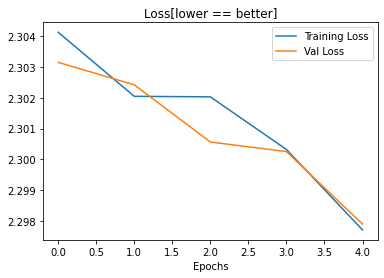

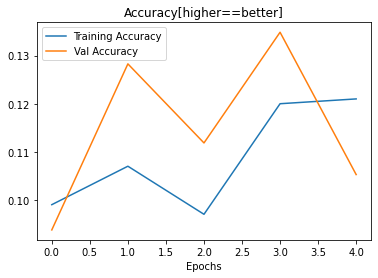

In [29]:
plot_history_curves(model_4_history)

> This is just an example of Data Augmenting with Sequential Layer to utilize the GPU, with the model it runs faster yet there is a much better and flexible way of doing this. Also our model isn't learning due to overfitting, which means our model is too complex(either we remove some of the data augmentations and more experiments) but let's move on for now. 

## CNN Transfer Learning [Feature Extraction]

**Transfer Learning** is using of a pretrained models' configurations from prelearned data and stored weights to solve our problem.

Since building the model and experimenting; trying different configurations our model's layers, adjusting hyperparameters(lr) takes so much time, thus using Transfer Learning will ease up our experimentation process.

this is called **Feature Extraction**

Why use `EfficientNetB0`?

>In general, to get higher accuracy, we need to use a “deeper” or larger model. But a larger model has many more parameters that make it slower to execute. 

>So, this is a balance we need to strike. For most of the Deep Learning deployments in the industry, we choose the smallest model that provides us with good enough accuracy. Thus, we need to experiment among many available models to pick the one that meets these criteria.

>On a side note, if you only care about achieving the highest accuracy no matter the impact to speed, then your approach could be to combine all these models using ensembling techniques! Indeed, ensembling is quite popular in academia and ML competitions.

[How to Choose the Best Keras Pre-Trained Model for Image Classification](https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4)


We're going to follow our model building and experimentation  [taken from MDBourkes slides](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/slides/05_transfer_learning_with_tensorflow_part_2_fine_tuning.pdf) for every model we're building from now on

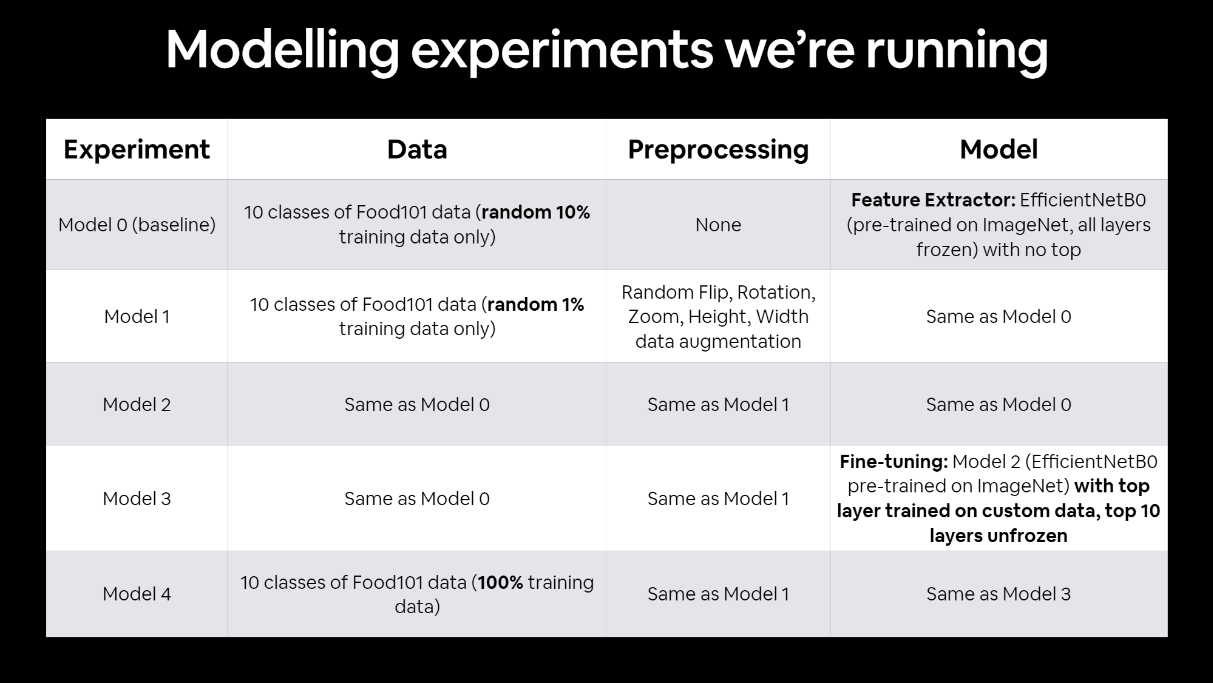

In [30]:
train_dir_10_percent = 'Food-Vision-REDO/datasets/10_percent_data_set/train/' 
train_dir_1_percent = 'Food-Vision-REDO/datasets/1_percent_data_set/train/'
train_data_dir = 'Food-Vision-REDO/datasets/all_data_set/train/'
test_data_dir = 'Food-Vision-REDO/datasets/all_data_set/test/'

Before we used **ImageDataGenerator** which used the CPU for data augmentation then passed-through  
**flow_from_directory** which only parses the images from the directory and is iterated throughout the training

So now we're going to use **image_data_set_from_directory** which in turn generates a dataset and batch files.

> * **flow_from_directory**: <keras.preprocessing.image.DirectoryIterator object at 0x000001294B219550>,  
> * **image_dataset_from_directory**: <BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [31]:
# preparing our data

IMG_SIZE = (224,224)

train_data_all = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_data_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical'
)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir_10_percent,
    image_size = IMG_SIZE,
    label_mode = 'categorical'
)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir_1_percent,
    image_size = IMG_SIZE,
    label_mode = 'categorical'
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_data_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical'
)

Found 7500 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Found 100 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Building Model 0 

**Experiment** - Model 0  
**Data** - 10% of the data set  
**Preprocessing** - None  
**Model** - Feature Extraction of a Transfer Learning Model  

In [32]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

tf_model_0 = tf.keras.Model(inputs, outputs)

tf_model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

tf_model_0_history = tf_model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        dir_name='./Food-Vision-REDO/transfer_learning',
        experiment_name='model_0'
    )]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning/logs/fits/model_0/20211114-211553


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
32/32 [==============================] - 13s 193ms/step - loss: 1.9377 - accuracy: 0.3660 - val_loss: 1.4938 - val_accuracy: 0.6118
Epoch 2/5
32/32 [==============================] - 5s 143ms/step - loss: 1.2090 - accuracy: 0.6960 - val_loss: 1.1492 - val_accuracy: 0.7007
Epoch 3/5
32/32 [==============================] - 4s 136ms/step - loss: 0.9094 - accuracy: 0.7920 - val_loss: 0.9598 - val_accuracy: 0.7500
Epoch 4/5
32/32 [==============================] - 4s 133ms/step - loss: 0.7535 - accuracy: 0.8210 - val_loss: 0.8531 - val_accuracy: 0.7582
Epoch 5/5
32/32 [==============================] - 4s 135ms/step - loss: 0.6398 - accuracy: 0.8470 - val_loss: 0.8127 - val_accuracy: 0.7730


In [33]:
tf_model_0.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.7974 - accuracy: 0.7680


[0.7974477410316467, 0.7680000066757202]

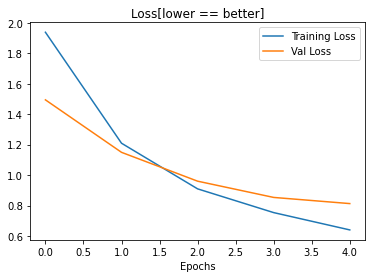

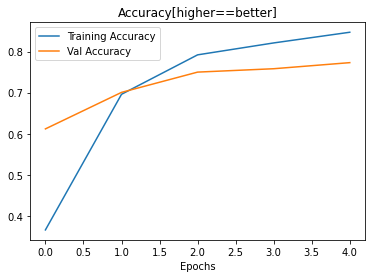

In [34]:
plot_history_curves(tf_model_0_history)

Our Model 0 performed better than our CNN from scratch by only using 10% of the dataset.

####  Building Model 1

**Experiment** - Model 1  
**Data** - 1%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction of a Transfer Learning Model 


In [35]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
    #tf.keras.layers.Rescaling(1./255), # no need for Effnet
])

In [36]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

tf_model_1 = tf.keras.Model(inputs, outputs)

tf_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

tf_model_1_history = tf_model_1.fit(
    train_data_1_percent,
    epochs=5,
    steps_per_epoch=len(train_data_1_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        dir_name='./Food-Vision-REDO/transfer_learning/',
        experiment_name='model_1'
    )]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/model_1/20211114-211633
Epoch 1/5
4/4 [==============================] - 12s 1s/step - loss: 2.2824 - accuracy: 0.1400 - val_loss: 2.2089 - val_accuracy: 0.1793
Epoch 2/5
4/4 [==============================] - 4s 1s/step - loss: 2.0344 - accuracy: 0.2400 - val_loss: 2.1259 - val_accuracy: 0.2286
Epoch 3/5
4/4 [==============================] - 4s 1s/step - loss: 1.8583 - accuracy: 0.4300 - val_loss: 2.0575 - val_accuracy: 0.2599
Epoch 4/5
4/4 [==============================] - 4s 1s/step - loss: 1.7498 - accuracy: 0.5900 - val_loss: 1.9694 - val_accuracy: 0.3388
Epoch 5/5
4/4 [==============================] - 3s 915ms/step - loss: 1.6050 - accuracy: 0.6700 - val_loss: 1.9069 - val_accuracy: 0.3799


In [37]:
tf_model_1.evaluate(test_data)

79/79 [==============================] - 6s 79ms/step - loss: 1.9264 - accuracy: 0.3508


[1.9264118671417236, 0.3508000075817108]

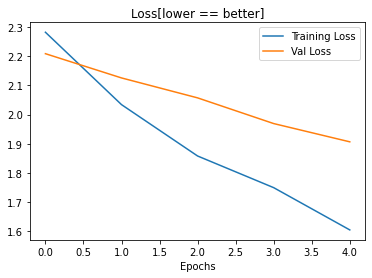

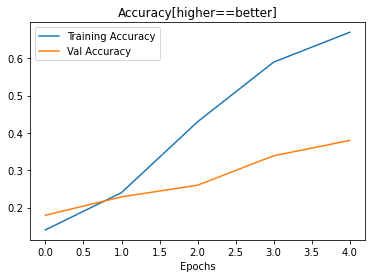

In [38]:
plot_history_curves(tf_model_1_history)

It's 1% of the dataset, yet it's performing okay since it's learning from the augmented data we fed.

####  Building Model 2

**Experiment** - Model 2  
**Data** - 10%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction of a Transfer Learning Model

In [39]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

tf_model_2 = tf.keras.Model(inputs, outputs)

tf_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

tf_model_2_history = tf_model_2.fit(
    train_data_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        dir_name='./Food-Vision-REDO/transfer_learning/',
        experiment_name='model_2'
    ), checkpoint_callback]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/model_2/20211114-211709
Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 1.9685 - accuracy: 0.3430
Epoch 00001: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 21s 466ms/step - loss: 1.9685 - accuracy: 0.3430 - val_loss: 1.5860 - val_accuracy: 0.5691
Epoch 2/5
32/32 [==============================] - ETA: 0s - loss: 1.3588 - accuracy: 0.6210
Epoch 00002: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 14s 426ms/step - loss: 1.3588 - accuracy: 0.6210 - val_loss: 1.2323 - val_accuracy: 0.6595
Epoch 3/5
32/32 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.7260
Epoch 00003: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 12s 385ms/step - loss: 1.0962 - accuracy: 0.7260 - val_loss: 1.0469 - val_accuracy: 0.71

In [40]:
tf_model_2.evaluate(test_data)

79/79 [==============================] - 6s 80ms/step - loss: 0.8856 - accuracy: 0.7452


[0.8855770230293274, 0.745199978351593]

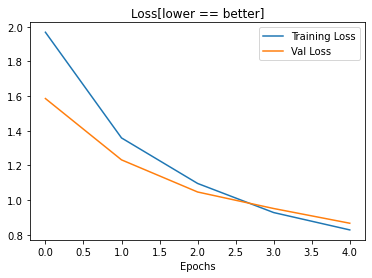

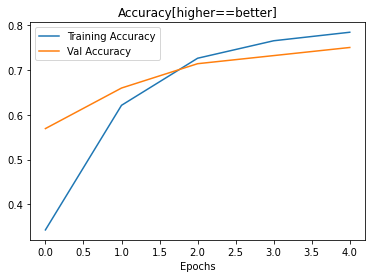

In [41]:
plot_history_curves(tf_model_2_history)

In [42]:
tf_model_2.evaluate(test_data)

79/79 [==============================] - 6s 78ms/step - loss: 0.8856 - accuracy: 0.7452


[0.8855770230293274, 0.745199978351593]

In [43]:
tf_model_2.load_weights(checkpoint_path)

just by using 10% of our dataset and augmenting it, we have reached a huge improvement within the dataset. 

####  Building Model 3

**Experiment** - Model 3   
**Data** - 10%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction + Fine Tuning
**Checkpoint** - From the final epoch of the previous model(tf_model_2)

* make last 10 trainable for `base_model` 
* use `tf_model_2` to compile and fit
* when fitting change `initial epoch` to tf_model_2's final `epoch`
* increase the `epochs` and `learning rate`

> 🔑 When increasing `learning_rate` also increase `epochs`

In [44]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False
    
tf_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

tf_model_3_history = tf_model_2.fit(
    train_data_10_percent,
    epochs=len(tf_model_2_history.epoch)+5,
    initial_epoch=tf_model_2_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(.25*len(test_data)),
    callbacks=[create_tensorboard_callback(
        dir_name='./Food-Vision-REDO/transfer_learning/',
        experiment_name='model_3'
    ), checkpoint_callback]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/model_3/20211114-211833
Epoch 5/10
32/32 [==============================] - ETA: 0s - loss: 0.7143 - accuracy: 0.7700
Epoch 00005: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 21s 443ms/step - loss: 0.7143 - accuracy: 0.7700 - val_loss: 0.7193 - val_accuracy: 0.7697
Epoch 6/10
32/32 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.8370
Epoch 00006: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 12s 357ms/step - loss: 0.5554 - accuracy: 0.8370 - val_loss: 0.7418 - val_accuracy: 0.7648
Epoch 7/10
32/32 [==============================] - ETA: 0s - loss: 0.5035 - accuracy: 0.8390
Epoch 00007: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 10s 328ms/step - loss: 0.5035 - accuracy: 0.8390 - val_loss: 0.7075 - val_accuracy: 0

In [45]:
def compare_history(original_history, new_history, initial_epochs):
    '''
    Input model_2 then new history to show frequency of the train and val loss
    '''
    
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']
    
    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']
    
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']
    
    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation History')
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

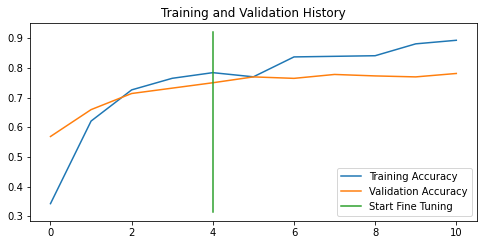

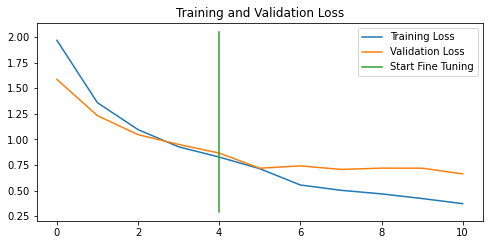

In [46]:
compare_history(tf_model_2_history, tf_model_3_history, initial_epochs=5)

In [47]:
tf_model_2.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.6994 - accuracy: 0.7756


[0.6994279026985168, 0.775600016117096]

From here we used `tf_model_2`'s previously learned weights, we also turned on training for EfficientNetb0's last 10 layers in the so we could let our model learn/train in those layers, we also increased `learning rate` and `epochs` so we could get more information and have our model learn more. 

####  Building Model 4

**Experiment** - Model 4   
**Data** - 100%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction + Fine Tuning


In [48]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

tf_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=['accuracy'])

tf_model_4_history = tf_model_2.fit(
    train_data_all,
    epochs=len(tf_model_2_history.epoch)+5,
    initial_epoch=tf_model_2_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(.25*len(test_data)),
    callbacks=[create_tensorboard_callback(
        dir_name='./Food-Vision-REDO/transfer_learning/',
        experiment_name='model_4'
    ), checkpoint_callback]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/model_4/20211114-211954
Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.7719
Epoch 00005: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
235/235 [==============================] - 61s 231ms/step - loss: 0.7054 - accuracy: 0.7719 - val_loss: 0.5928 - val_accuracy: 0.8174
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.8124
Epoch 00006: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
235/235 [==============================] - 54s 228ms/step - loss: 0.5819 - accuracy: 0.8124 - val_loss: 0.4990 - val_accuracy: 0.8339
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 0.5243 - accuracy: 0.8244
Epoch 00007: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
235/235 [==============================] - 46s 195ms/step - loss: 0.5243 - accuracy: 0.8244 - val_loss: 0.4715 - val

In [49]:
tf_model_2.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.4646 - accuracy: 0.8496


[0.4645596742630005, 0.8496000170707703]

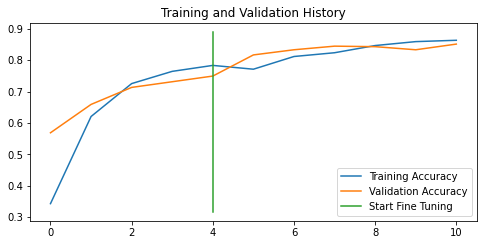

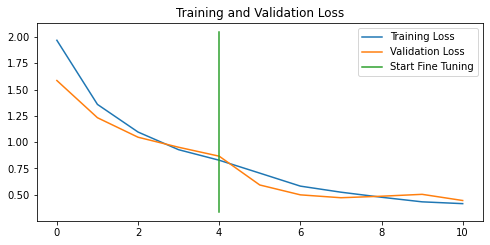

In [50]:
compare_history(tf_model_2_history, tf_model_4_history, initial_epochs=5)

Again we used `tf_model_2`'s; prelearned weights, activated training for EfficientNet's last 10 layers, increased the `learning rate` and `epochs` which has been trained on the full 10 classes dataset